In [1]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score,make_scorer
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import cross_val_score

In [2]:
#load data
mydata = pd.read_csv('merged_data.csv')

In [3]:
#look at data
mydata


,Unnamed: 0,Year,Month,ISHMT,discharge_rate,date,County,PM2.5,PM10
0,0,2020,6,Acute upper respiratory infections & influenza...,0.020226,2020-06-01,Cork,2.449595,4.925600
1,1,2020,7,Acute upper respiratory infections & influenza...,0.023597,2020-07-01,Cork,2.918698,8.976464
2,2,2020,8,Acute upper respiratory infections & influenza...,0.038767,2020-08-01,Cork,5.503203,11.047632
3,3,2020,9,Acute upper respiratory infections & influenza...,0.062364,2020-09-01,Cork,5.348747,11.373366
4,4,2020,10,Acute upper respiratory infections & influenza...,0.038767,2020-10-01,Cork,6.587163,12.050000
...,...,...,...,...,...,...,...,...,...
597,597,2023,8,Pneumonia (J12-J18),0.190482,2023-08-01,Dublin,4.065971,8.849873
598,598,2023,9,Pneumonia (J12-J18),0.179160,2023-09-01,Dublin,7.197300,13.106326
599,599,2023,10,Pneumonia (J12-J18),0.238436,2023-10-01,Dublin,6.902304,13.438059
600,600,2023,11,Pneumonia (J12-J18),0.265743,2023-11-01,Dublin,7.755754,13.776940


In [4]:
#drop first col not needed
mydata.drop(mydata.columns[0], axis=1, inplace=True)
mydata

,Year,Month,ISHMT,discharge_rate,date,County,PM2.5,PM10
0,2020,6,Acute upper respiratory infections & influenza...,0.020226,2020-06-01,Cork,2.449595,4.925600
1,2020,7,Acute upper respiratory infections & influenza...,0.023597,2020-07-01,Cork,2.918698,8.976464
2,2020,8,Acute upper respiratory infections & influenza...,0.038767,2020-08-01,Cork,5.503203,11.047632
3,2020,9,Acute upper respiratory infections & influenza...,0.062364,2020-09-01,Cork,5.348747,11.373366
4,2020,10,Acute upper respiratory infections & influenza...,0.038767,2020-10-01,Cork,6.587163,12.050000
...,...,...,...,...,...,...,...,...
597,2023,8,Pneumonia (J12-J18),0.190482,2023-08-01,Dublin,4.065971,8.849873
598,2023,9,Pneumonia (J12-J18),0.179160,2023-09-01,Dublin,7.197300,13.106326
599,2023,10,Pneumonia (J12-J18),0.238436,2023-10-01,Dublin,6.902304,13.438059
600,2023,11,Pneumonia (J12-J18),0.265743,2023-11-01,Dublin,7.755754,13.776940


## Random Forest
#### Build for mydata_pre_feb2022 (up to the end of the COVID restrictions)

In [5]:
#convert categorical variables
mydata_model = pd.get_dummies(mydata, columns=['ISHMT', 'County'], drop_first=True)


In [6]:
#get rid of date it is not needed
mydata_model = mydata_model.drop(columns=['date'])

#sort X (features) and y (target)
X = mydata_model.drop(columns=['discharge_rate'])
y = mydata_model['discharge_rate']

#split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Random Forest RMSE: 0.04
Test R² Score: 0.7036084157297653
Test RMSE: 0.04187083572235858


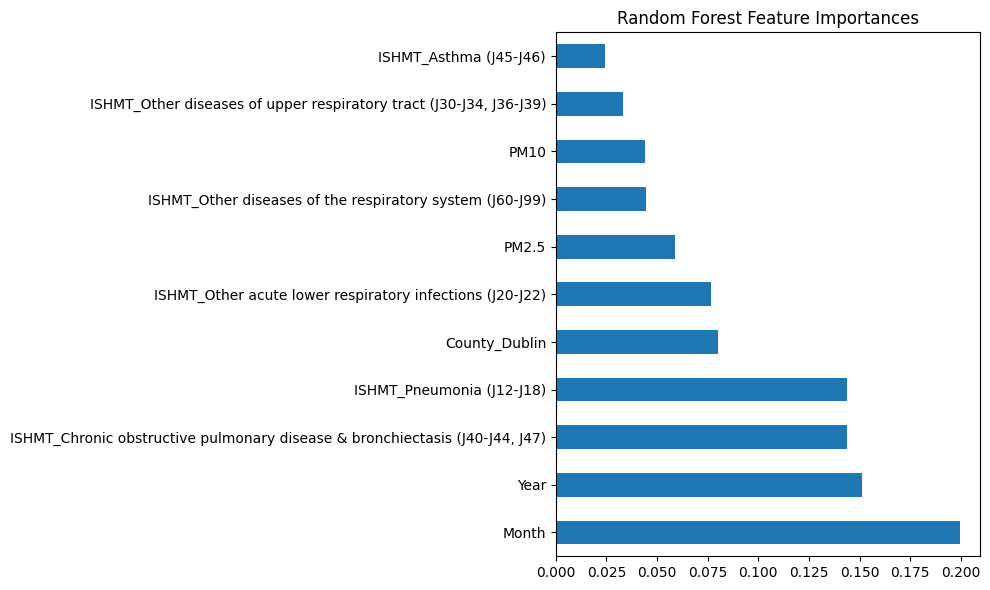

In [7]:
#build random forest model
model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

#print scores
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print("Test R² Score:", r2_score(y_test, y_pred_rf))
print("Test RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))

#plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()

In [8]:
#tune hyperparameters in this model use baysian optimiser for best hyperparameters
rf = RandomForestRegressor(random_state=42)

#define hyperparameters
param_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical([ 'sqrt', 'log2'])
}

#add in baysian optimiser for hyperparameter selection
opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

#fit the searched optimal hyperparameters
opt.fit(X_train, y_train)

#best hyperparameters
print("Best Hyperparameters:", opt.best_params_)
best_rf_bayes = opt.best_estimator_

#predict
y_pred_bayes = best_rf_bayes.predict(X_test)

#print scores
print("Test R² Score:", r2_score(y_test, y_pred_bayes))
print("Test RMSE:", mean_squared_error(y_test, y_pred_bayes, squared=False))

#r2 scores across CV folds
cv_r2_scores = cross_val_score(best_rf_bayes, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores)
print("Mean CV R²:", np.mean(cv_r2_scores))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

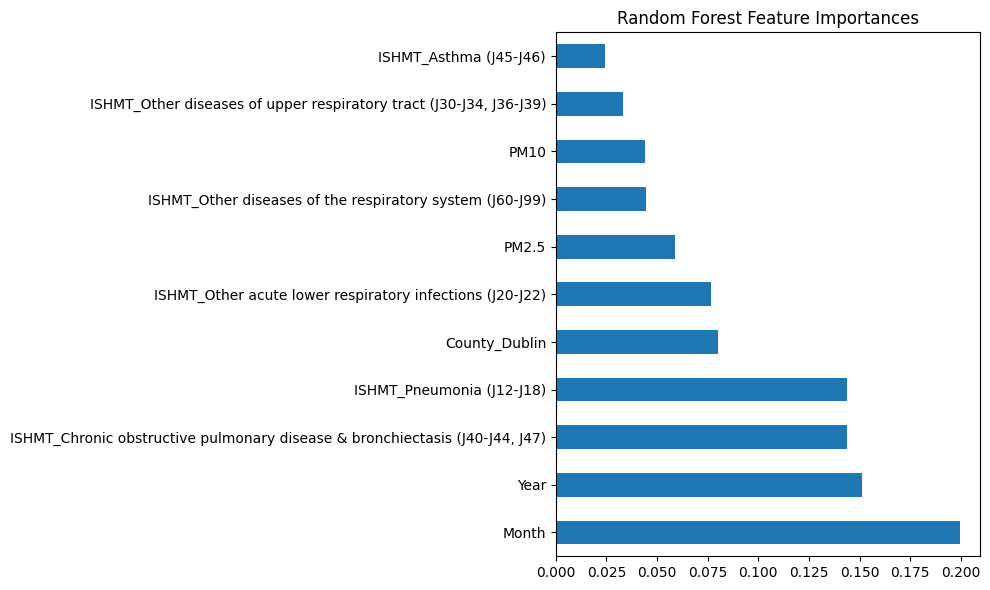

In [9]:
#feature importances
importances = best_rf_bayes.feature_importances_

#plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()


In [10]:
#hyperparameter tunning using gridsearch this time
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [1, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['sqrt', 'log2'] 
}
rf_best_model = RandomForestRegressor(random_state=42)

#grid Search with cross validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

#besst hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#print model with best hyperparameters
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

#r2 scores across CV folds
cv_r2_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validated R² Scores:", cv_r2_scores)
print("Mean CV R²:", np.mean(cv_r2_scores))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R² Score: 0.6259715870877605
RMSE: 0.047036066147236016
Cross-Validated R² Scores: [0.59543514 0.62324404 0.62995873 0.59693841 0.57596439]
Mean CV R²: 0.6043081420985641


Feature importances:
ISHMT_Pneumonia (J12-J18)                                                      0.155350
Month                                                                          0.135985
PM2.5                                                                          0.129666
ISHMT_Chronic obstructive pulmonary disease & bronchiectasis (J40-J44, J47)    0.129473
Year                                                                           0.108276
PM10                                                                           0.105995
ISHMT_Other acute lower respiratory infections (J20-J22)                       0.059075
County_Dublin                                                                  0.053709
ISHMT_Other diseases of the respiratory system (J60-J99)                       0.048053
ISHMT_Other diseases of upper respiratory tract (J30-J34, J36-J39)             0.037345
ISHMT_Asthma (J45-J46)                                                         0.037074
dtype: floa

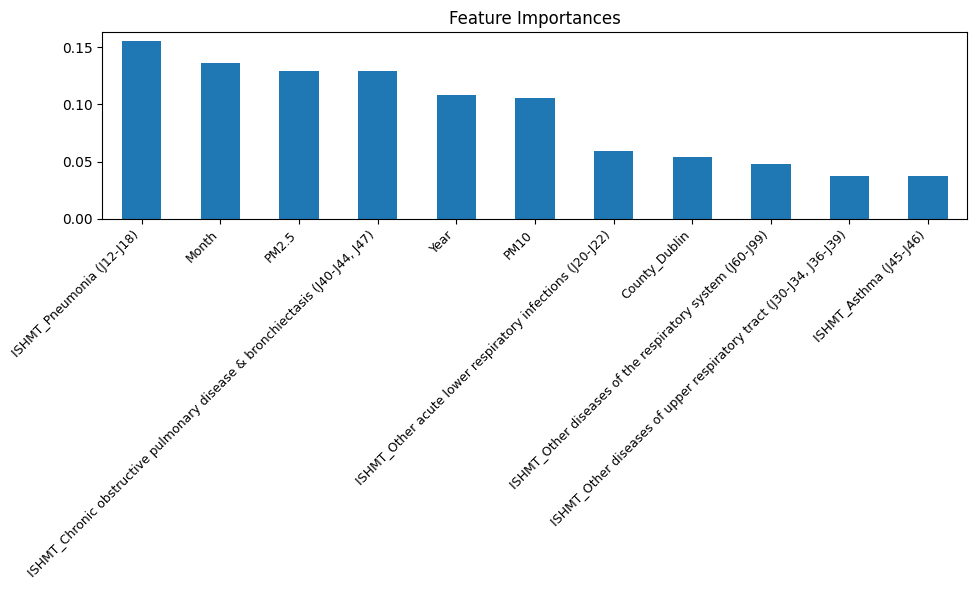

In [11]:
#get feature importance
importances = best_rf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(importances, index=feature_names)

#sort descending & print
feat_importances = feat_importances.sort_values(ascending=False)
print("Feature importances:")
print(feat_importances)

#plot
feat_importances.plot(kind='bar', figsize=(10,6), title='Feature Importances')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()

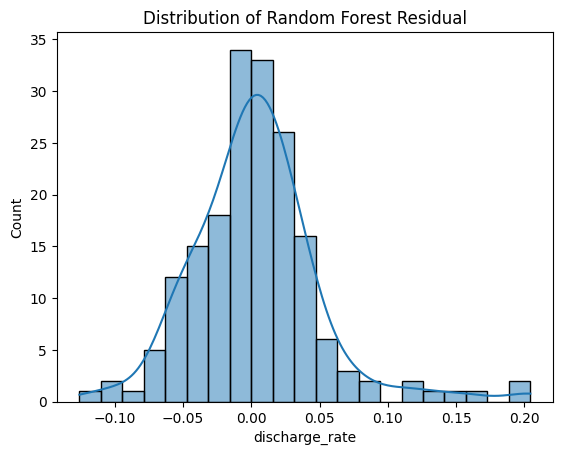

In [12]:
#plot residuals
rf_residuals = y_test - best_rf.predict(X_test)
sns.histplot(rf_residuals, kde=True)
plt.title("Distribution of Random Forest Residual")
plt.show()


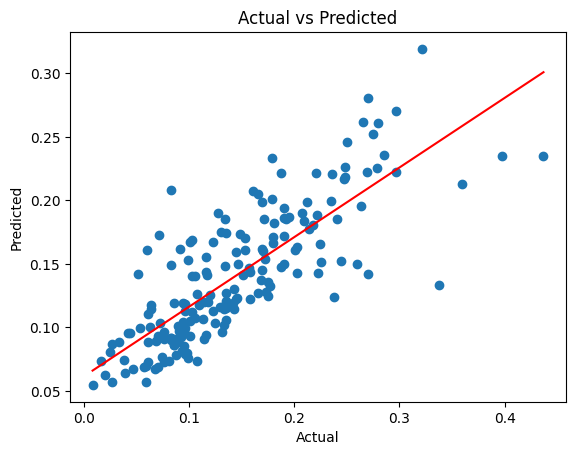

In [13]:
#plot actuals vs prredicted
predictions = best_rf.predict(X_test)
plt.scatter(y_test, predictions)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predictions, 1))(np.unique(y_test)), color='red')  # regression line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

In [14]:
# Show the predictions
print(predictions)

[0.07294032 0.14846663 0.2351532  0.16730555 0.13747977 0.10150224
 0.07376968 0.10542353 0.16191216 0.096684   0.0743683  0.1007312
 0.07556379 0.31934155 0.1222023  0.16212778 0.14245232 0.1774315
 0.14776841 0.06853249 0.06379107 0.2254917  0.17385267 0.23382334
 0.13032114 0.12483325 0.16870041 0.08130734 0.1991345  0.05716217
 0.18654785 0.11189776 0.16076642 0.22057362 0.1498226  0.18042431
 0.09748053 0.10771286 0.07389829 0.15142736 0.11621817 0.11945093
 0.15422246 0.2071842  0.06914101 0.1595588  0.14511065 0.10360728
 0.09938252 0.18559091 0.19946916 0.22229853 0.09287572 0.16361245
 0.22612779 0.14144849 0.17121168 0.11256414 0.0673965  0.16626327
 0.16743984 0.16132073 0.14962334 0.18578072 0.15009053 0.10061257
 0.21283378 0.2702186  0.11760296 0.12299423 0.1192852  0.08727562
 0.1411806  0.14694285 0.17542844 0.1839528  0.09664502 0.19561348
 0.21863591 0.08838871 0.14248793 0.14402362 0.26180052 0.12245093
 0.13327424 0.11488245 0.0887954  0.19051947 0.12808945 0.172201

Random Forest RMSE: 0.05


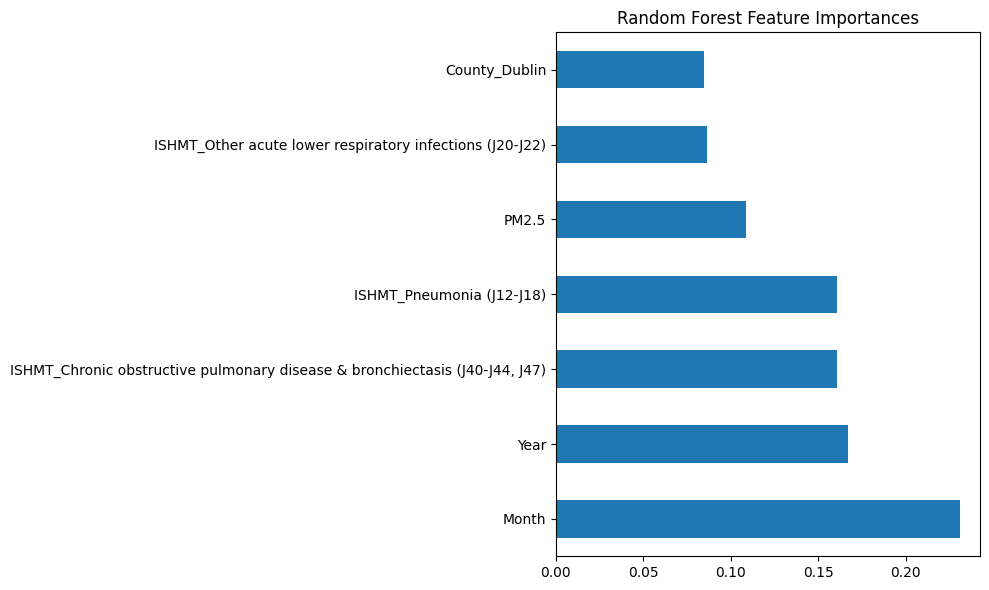

In [15]:
#drop the non-important features
#get rid of date it is not needed
mydata_model = mydata_model.drop(columns=['PM10','ISHMT_Other diseases of the respiratory system (J60-J99)','ISHMT_Other diseases of upper respiratory tract (J30-J34, J36-J39)','ISHMT_Asthma (J45-J46)'])

#sort X (features) and y (target)
X = mydata_model.drop(columns=['discharge_rate'])
y = mydata_model['discharge_rate']

#split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#build random forest model
model_reduced = RandomForestRegressor(n_estimators=500, random_state=42)
model_reduced.fit(X_train, y_train)
y_pred_rf = model_reduced.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f"Random Forest RMSE: {rmse_rf:.2f}")

#plot feature importances
importances = pd.Series(model_reduced.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()

In [16]:
#hyperparameters
param_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2'])
}

#bayesian optimiser search
opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=2,
    random_state=42
)

#fit & print
opt.fit(X_train, y_train)
print("Best Hyperparameters:", opt.best_params_)
best_rf_bayes = opt.best_estimator_
y_pred_bayes = best_rf_bayes.predict(X_test)
print("Test R² Score:", r2_score(y_test, y_pred_bayes))
print("Test RMSE:", mean_squared_error(y_test, y_pred_bayes, squared=False))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi